<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


##Experiments Rotation Representations and Testing

In [ ]:
eul = np.array([dataset.X[153]])
rots = Tools.euler_to_rots(eul)

In [ ]:
ort = Tools.rots_to_ort6d(rots)

In [ ]:
transformed = dataset.eul_to_pos(np.array([dataset.X[-1]]))

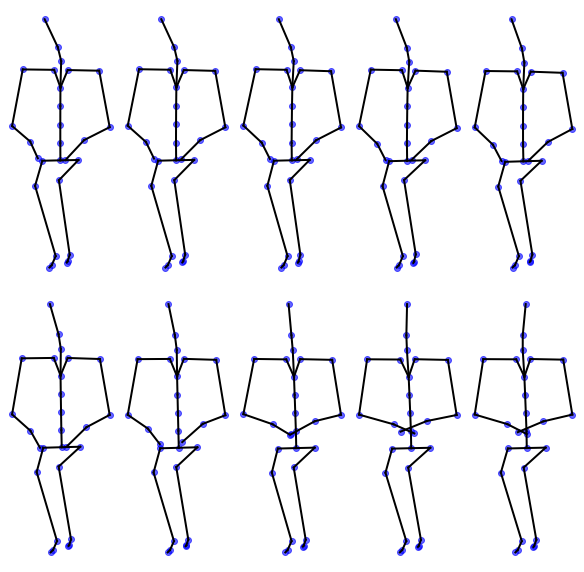

In [ ]:
fig = dataset.stickfigure(transformed[0])

##Experiments Mocap Player

In [ ]:
import IPython
def nb_play_mocap(mocap, mf, meta=None, frame_time=1/30, scale=1, camera_z=500, base_url=None):
    data_template = 'var dataBuffer = `$$DATA$$`;'
    data_template += 'var metadata = $$META$$;'
    data_template += 'start(dataBuffer, metadata, $$CZ$$, $$SCALE$$, $$FRAMETIME$$);'
    dir_path = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo' # os.path.dirname(os.path.realpath(__file__))


    if base_url is None:
        base_url = os.path.join(dir_path, 'mocapplayer/playBuffer.html')
    
    # print(dir_path)

    if mf == 'bvh':
        pass
    elif mf == 'pos':
        cols = list(mocap.values.columns)
        for c in cols:
            if 'rotation' in c:
                cols.remove(c)
        
        data_csv = mocap.values.to_csv(index=False, columns=cols)

        if meta is not None:
            lines = [','.join(item) for item in meta.astype('str')]
            meta_csv = '[' + ','.join('[%s]'%l for l in lines) +']'            
        else:
            meta_csv = '[]'
        
        data_assigned = data_template.replace('$$DATA$$', data_csv)
        data_assigned = data_assigned.replace('$$META$$', meta_csv)
        data_assigned = data_assigned.replace('$$CZ$$', str(camera_z))
        data_assigned = data_assigned.replace('$$SCALE$$', str(scale))
        data_assigned = data_assigned.replace('$$FRAMETIME$$', str(frame_time))

    else:
        return
    
    

    with open(os.path.join(dir_path, 'mocapplayer/data.js'), 'w') as oFile:
        oFile.write(data_assigned)

    nb_ext = '/usr/local/share/jupyter/nbextensions/google.colab'
    ! cp {os.path.join(dir_path, 'mocapplayer/data.js')} {os.path.join(nb_ext, 'data.js')}

In [ ]:
nb_play_mocap(transformed[0], 'pos')

In [ ]:
import IPython
IPython.display.HTML(filename='/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/playBuffer.html')

In [ ]:
! touch /content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/test2.js

In [ ]:
! touch /content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/test2.js

In [ ]:

import IPython
from google.colab import output

IPython.display.HTML(filename='/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/playBuffer.html')


In [ ]:
! cp /content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/js/skeletonFactory.js /usr/local/share/jupyter/nbextensions/google.colab/skeletonFactory.js



In [ ]:
def draw_stickfigure3d(mocap_track, frame, data=None, joints=None, draw_names=False, ax=None, figsize=(8,8)):
    from mpl_toolkits.mplot3d import Axes3D
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d') 
    
    if joints is None:
        joints_to_draw = mocap_track.skeleton.keys()
    else:
        joints_to_draw = joints
    
    if data is None:
        df = mocap_track.values
    else:
        df = data
        
    for joint in joints_to_draw:
        parent_x = df['%s_Xposition'%joint][frame]
        parent_y = df['%s_Zposition'%joint][frame]
        parent_z = df['%s_Yposition'%joint][frame]
        # ^ In mocaps, Y is the up-right axis 

        ax.scatter(xs=parent_x, 
                   ys=parent_y,  
                   zs=parent_z,  
                   alpha=0.6, c='b', marker='o')

        
        children_to_draw = [c for c in mocap_track.skeleton[joint]['children'] if c in joints_to_draw]
        
        for c in children_to_draw:
            child_x = df['%s_Xposition'%c][frame]
            child_y = df['%s_Zposition'%c][frame]
            child_z = df['%s_Yposition'%c][frame]
            # ^ In mocaps, Y is the up-right axis

            ax.plot([parent_x, child_x], [parent_y, child_y], [parent_z, child_z], 'k-', lw=2, c='black')
            
        if draw_names:
            ax.text(x=parent_x + 0.1, 
                    y=parent_y + 0.1,
                    z=parent_z + 0.1,
                    s=joint,
                    color='rgba(0,0,0,0.9)')

    return ax


def sketch_move(mocap_track, data=None, ax=None, figsize=(16,8)):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    
    if data is None:
        data = mocap_track.values

    for frame in range(0, data.shape[0], 4):
#         draw_stickfigure(mocap_track, f, data=data, ax=ax)
        
        for joint in mocap_track.skeleton.keys():
            children_to_draw = [c for c in mocap_track.skeleton[joint]['children']]
            
            parent_x = data['%s_Xposition'%joint][frame]
            parent_y = data['%s_Yposition'%joint][frame]
            
            frame_alpha = frame/data.shape[0]
            
            for c in children_to_draw:
                child_x = data['%s_Xposition'%c][frame]
                child_y = data['%s_Yposition'%c][frame]
                
                ax.plot([parent_x, child_x], [parent_y, child_y], '-', lw=1, color='gray', alpha=frame_alpha)



##Version Control

In [ ]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'nb_mocap_player is working. try adding another layer to generator?'

[main d32bc68] nb_mocap_player is working. try adding another layer to generator?
 5 files changed, 12 insertions(+), 11 deletions(-)
 rewrite setup.ipynb (70%)


In [ ]:
! git add .

In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 15, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (15/15), done.
Writing objects: 100% (15/15), 860.86 KiB | 5.66 MiB/s, done.
Total 15 (delta 8), reused 0 (delta 0)
remote: Resolving deltas: 100% (8/8), completed with 8 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   e59ba74..d32bc68  main -> main


##Setup Dataset

In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from tools import Tools, Metrics
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
data = {}
data['X'] = dataset.X
data['X_val'] = dataset.X_val
data['Y_ord'] = dataset_2.Y_ord
data['Y_ord_val'] = dataset_2.Y_ord_val
data['Y_vec'] = dataset_2.Y_vec
data['Y_vec_val'] = dataset_2.Y_vec_val
data['data'] = dataset_2.data
data['feature_names'] = dataset_2.feature_names
data['n_features'] = dataset_2.n_features

In [30]:
# dataset2 = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200, validation=0.1, representation='eul')
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200, validation=0, representation='eul')
# dataset = Dataset(["sadness"], path=dataset_dir, step_size=10, frames=200, validation=0, representation='eul')

anger


100%|██████████| 65/65 [00:09<00:00,  6.93it/s]


joy


100%|██████████| 29/29 [00:04<00:00,  6.20it/s]


fear


100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


neutral


100%|██████████| 88/88 [00:16<00:00,  5.33it/s]


sadness


100%|██████████| 47/47 [00:10<00:00,  4.52it/s]


pride


100%|██████████| 24/24 [00:05<00:00,  4.21it/s]


In [ ]:
import copy
dataset_2 = copy.deepcopy(dataset)

In [ ]:
Dataset.balance(dataset2)

No. of samples in each class will be:  1114


##Experiments Model

In [19]:
config = {       # change hyperparams here
        'latent_dim' : 300,
        'in_shape' : (200, 138),   # (dataset.frames, dataset.n_features*2),  # 6d representation
        'n_classes' : 6,             # dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 30,
        'batch_size' : 256,
        'n_critic' : 1,
        'n_generator' : 3,
        'dataset_balanced' : False,
        'critic_batch_norm' : False,    # DONT USE
        'critic_instance_norm' : False, # not working
        'critic_layer_norm' : False,    
        'critic_weight_norm' : False,   # not working
        'critic_cond_layer_norm' : True, # not working
        'generator_batch_norm' : False,
        'generator_layer_norm' : True, # conditional layer norm
        'generator_layer_norm_plus' : False, # custom MLP layers to decide alpha and beta
        'critic_dropout' : 0,
        'gp_weight' : 10.0,      # for the gradient penalty used in critic
        'note' : 'decreased n_critic',
        'validation' : False,
        'only_critic' : False,
        'representation' : '6d',
        'wrong_labels' : False,   # not implemented yet
        'critic_train_after' : 0  # train critic after generator loss decreases 1 time
      }

In [36]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

(None, 200, 138) (None, 200, 1)


In [35]:
generator = define_norm_generator(config)

(None, 200, 138) (None, 200, 1)


In [37]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset, outputs_path, 'critic_cond_layer_norm_', critic, generator)

In [38]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.5, beta_2=0.9
)
# critic_optimizer = tf.keras.optimizers.RMSprop(0.0001)

critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [ ]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/one_class_2022.02.28-13:42:08/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

In [39]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

>1, 1/43, c_loss=10.000, g_loss=nan, val_loss=0.000


KeyboardInterrupt: ignored

In [ ]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models'):
  if 'epoch_1' not in os.listdir('/content/drive/MyDrive/CS490/models/' + dir):
    ! rm -rf {'/content/drive/MyDrive/CS490/models/' + dir}

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/6d_repr2022.06.01-13:01:49

In [ ]:
import json
with open('/content/drive/MyDrive/CS490/models/6d_critic_less2022.06.08-20:15:58/epoch_9/train_metrics.txt', 'r') as f:
  train_metrics = json.load(f)

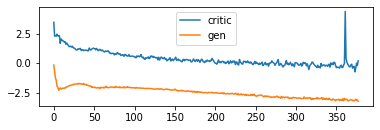

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(np.array(train_metrics)[0], label='critic')
plt.plot(np.array(train_metrics)[1], label='gen')
plt.legend()

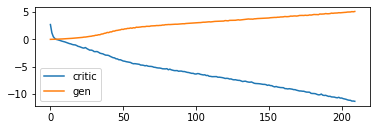

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(np.array(train_metrics)[0], label='critic')
plt.plot(np.array(train_metrics)[1], label='gen')
plt.legend()

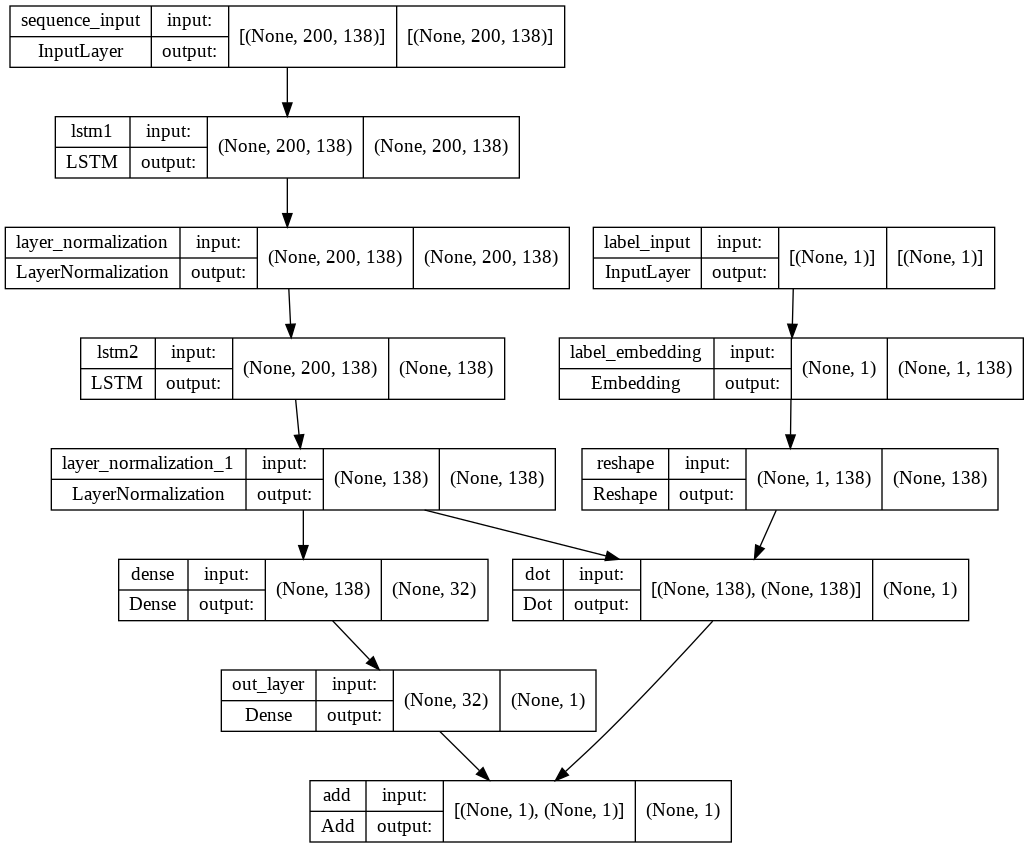

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(critic, show_shapes=True, show_layer_names=True)

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 200, 138)     0           ['lat_upsample[0][0]']           
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:48:19/epoch_1', 'train_metrics.txt')) as file:
  tm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]

<function matplotlib.pyplot.figure>

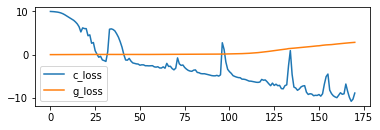

In [ ]:
Base_WGAN.plot_history(gan.train_metrics)

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'cm.txt')) as file:
  cm = json.load(file)

##Extras

In [34]:
import os, sys
main_dir = os.getcwd()
sys.path.append(os.path.join(main_dir, 'models'))
os.chdir(main_dir)
# append a path to any directory that the tensorflow_addons is installed in.
sys.path.append('/content/drive/MyDrive/CS490')
main_dir = os.getcwd()
sys.path.append(main_dir)
from models.generator_models.norm_generator import ConditionalBatchNorm, ConditionalLayerNormPlus, ConditionalLayerNorm

import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils

def define_projection_critic(config):
    init = keras.initializers.RandomNormal(stddev=config['init_std'])
    in_label = layers.Input(shape=(1,), name='label_input')
    li = layers.Embedding(config['n_classes'], config['in_shape'][1], name='label_embedding')(in_label)  # had 50 nodes originally
    li = layers.Reshape((-1,))(li)

    in_seq = layers.Input(shape=config['in_shape'], name='sequence_input')

    hidden1 = layers.LSTM(config['in_shape'][1], name='lstm1', return_sequences=True, kernel_initializer=init, unroll=True)(in_seq)
    if config['critic_batch_norm']:
      hidden1 = layers.BatchNormalization()(hidden1)
    if config['critic_instance_norm']:
      hidden1 = tfa.layers.InstanceNormalization()(hidden1)
    if config['critic_layer_norm']:
      hidden1 = layers.LayerNormalization(axis=1 , center=True , scale=True)(hidden1)
    if config['critic_weight_norm']:
      hidden1 = layers.WeightNormalization(axis=1 , center=True , scale=True)(hidden1)
    if config['critic_dropout'] > 0:
      hidden1 = layers.Dropout(config['critic_dropout'])(hidden1)
    if config['critic_cond_layer_norm']:
      repeat = layers.RepeatVector(config['in_shape'][0], name='repeat')(in_label)
      print(hidden1.shape, repeat.shape)
      merged1 = layers.Concatenate(axis=2, name='merge1')([hidden1, repeat])
      hidden1 = layers.TimeDistributed(ConditionalLayerNorm(n_classes=config['n_classes'], name='conditional_layer_norm1'))(merged1)

    hidden2 = layers.LSTM(hidden1.shape[2], name='lstm2', kernel_initializer=init, unroll=True)(hidden1)   
    if config['critic_batch_norm']:
      hidden2 = layers.BatchNormalization()(hidden2)
    if config['critic_instance_norm']:
      hidden2 = tfa.layers.InstanceNormalization()(hidden2)
    if config['critic_layer_norm']:
      hidden2 = layers.LayerNormalization(axis=1 , center=True , scale=True)(hidden2)
    if config['critic_weight_norm']:
      hidden2 = layers.WeightNormalization(axis=1 , center=True , scale=True)(hidden2)
    if config['critic_dropout'] > 0:
      hidden2 = layers.Dropout(config['critic_dropout'])(hidden2)
  
    dot = layers.Dot(axes=(1))([hidden2, li])

    # process sequence data more separately
    dense = layers.Dense(32, name='dense', activation='relu', kernel_initializer=init)(hidden2)
    out_layer = layers.Dense(1, activation='linear', name='out_layer', kernel_initializer=init)(dense)

    out = layers.Add()([dot, out_layer])
    model = keras.Model([in_label, in_seq], out, name='critic')
    return model

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
    
def define_norm_generator(config):
  init = keras.initializers.RandomNormal(stddev=config['init_std'])
  in_label = layers.Input(shape=(1,), name='label_input')
  if config['generator_batch_norm'] or config['generator_layer_norm']:
    li = in_label
  else:
    li = layers.CategoryEncoding(num_tokens=config['n_classes'], output_mode="one_hot", name='one-hot')(in_label)
  li = layers.RepeatVector(config['in_shape'][0], name='repeat')(li)

  in_lat = layers.Input(shape=(config['latent_dim'],), name='seq_input')
  lat = layers.Dense( config['in_shape'][0] * config['in_shape'][1], name='lat_upsample')(in_lat)
  lat = layers.Reshape((config['in_shape'][0], config['in_shape'][1]))(lat)
  # merge = keras.layers.Concatenate(name='concatenate', axis=2)([li, lat])

  hidden1 = layers.LSTM(config['in_shape'][1], name='LSTM1', return_sequences=True, kernel_initializer=init)(lat)
  print(hidden1.shape, li.shape)
  merged = layers.Concatenate(axis=2, name='concatenate')([hidden1, li])
  if config['generator_batch_norm']:
    merged = layers.TimeDistributed(ConditionalBatchNorm(n_classes=config['n_classes'], name='conditional_batch_norm'))(merged)
  if config['generator_layer_norm']:
    merged = layers.TimeDistributed(ConditionalLayerNorm(n_classes=config['n_classes'], name='conditional_layer_norm'))(merged)
  if config['generator_layer_norm_plus']:
    merged = layers.TimeDistributed(ConditionalLayerNormPlus(n_classes=config['n_classes'], name='conditional_layer_norm_plus'))(merged)
  hidden2 = layers.LSTM(config['in_shape'][1]*2, name='LSTM2', return_sequences=True, kernel_initializer=init)(merged)
  merged2 = layers.Concatenate(axis=2, name='concatenate2')([hidden2, li])
  if config['generator_batch_norm']:
    merged2 = layers.TimeDistributed(ConditionalBatchNorm(n_classes=config['n_classes'], name='conditional_batch_norm2'))(merged2)
  if config['generator_layer_norm']:
    merged2 = layers.TimeDistributed(ConditionalLayerNorm(n_classes=config['n_classes'], name='conditional_layer_norm2'))(merged2)
  if config['generator_layer_norm_plus']:
    merged2 = layers.TimeDistributed(ConditionalLayerNormPlus(n_classes=config['n_classes'], name='conditional_layer_norm_plus2'))(merged2)
  hidden3 = layers.LSTM(config['in_shape'][1], name='out_LSTM', return_sequences=True, kernel_initializer=init)(merged2)
  merged3 = layers.Concatenate(axis=2, name='concatenate3')([hidden3, li])
  if config['generator_batch_norm']:
    merged3 = layers.TimeDistributed(ConditionalBatchNorm(n_classes=config['n_classes'], name='conditional_batch_norm3'))(merged3)
  if config['generator_layer_norm']:
    merged3 = layers.TimeDistributed(ConditionalLayerNorm(n_classes=config['n_classes'], name='conditional_layer_norm3'))(merged3)
  if config['generator_layer_norm_plus']:
    merged3 = layers.TimeDistributed(ConditionalLayerNormPlus(n_classes=config['n_classes'], name='conditional_layer_norm_plus3'))(merged3)
  model = keras.Model([in_label, in_lat], merged3, name='generator')
  return model

class ConditionalBatchNorm(layers.Layer):
  def __init__(self, n_classes, **kwargs):
    super().__init__(**kwargs)
    self.n_classes = n_classes
  def build(self, input_shape):
    self.seq_len = input_shape[1] - 1
    self.gamma = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='gamma')
    self.beta = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='beta')
    self.moving_mean = self.add_weight(shape=[1, self.seq_len],
        initializer='zeros', trainable=False, name='moving_mean')
    self.moving_var = self.add_weight(shape=[1, self.seq_len], 
        initializer='zeros', trainable=False, name='moving_var')
    self.alpha = 0.99  # alpha is the decay parameter for exponential moving average
    # it is 0.99 in keras.layers.BatchNormalization so I use it too.
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, 1], axis=1)
    labels = tf.cast(labels, tf.int32)
    beta = tf.gather(self.beta, labels)
    # print(beta)
    beta = tf.reshape(beta, (-1, beta.shape[-1]))
    # print(beta)
    gamma = tf.gather(self.gamma, labels)
    gamma = tf.reshape(gamma, (-1, gamma.shape[-1]))
    if training:
      mean, var = tf.nn.moments(x, axes=(0), keepdims=True)
      self.moving_mean.assign(self.alpha * self.moving_mean + (1-self.alpha)*mean)
      self.moving_var.assign(self.alpha * self.moving_var + (1-self.alpha)*var)
      # mean = tf.repeat(mean, labels.shape[0], axis=0)
      # var = tf.repeat(var, labels.shape[0], axis=0)
      # print(x.shape, mean.shape, var.shape, beta.shape, gamma.shape)
      output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
    else:
      output = tf.nn.batch_normalization(x, self.moving_mean, self.moving_var, beta, gamma, self.eps)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)
  def get_config(self):
    config = super().get_config()
    config.update({
        "n_classes": self.n_classes
    })
    return config

# Conditional layer norm but calculate beta and gammas separately using MLPs.
class ConditionalLayerNormPlus(layers.Layer):
  def __init__(self, n_classes, **kwargs):
    super().__init__(**kwargs)
    self.n_classes = n_classes
  def build(self, input_shape):
    self.seq_len = input_shape[1] - self.n_classes
    # self.gamma_embedding = layers.Embedding(1, self.seq_len, name='gamma_embedding')
    self.gamma_dense1 = layers.Dense(int(self.seq_len / 2), name='gamma_dense1')
    self.gamma_dense2 = layers.Dense(self.seq_len, name='gamma_dense2')
    # self.beta_embedding = layers.Embedding(1, self.seq_len, name='beta_embedding')
    self.beta_dense1 = layers.Dense(int(self.seq_len / 2), name='beta_dense1')
    self.beta_dense2 = layers.Dense(self.seq_len, name='beta_dense2')
    self.reshape = layers.Reshape((-1,))
    self.layer_norm = layers.LayerNormalization(center=False, scale=False)
    self.eps = 0.00001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, self.n_classes], axis=1)
    # print(x.shape, labels.shape)
    # gamma = self.gamma_embedding(labels)
    # gamma = self.reshape(gamma)
    gamma = self.gamma_dense1(labels)
    gamma = self.gamma_dense2(gamma)
    # beta = self.beta_embedding(labels)
    # beta = self.reshape(beta)
    beta = self.beta_dense1(labels)
    beta = self.beta_dense2(beta)
    # print(gamma.shape, beta.shape)
    output = tf.math.add(tf.math.multiply(self.layer_norm(x), gamma), beta)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)
  def get_config(self):
    config = super().get_config()
    config.update({
        "n_classes": self.n_classes
    })
    return config

class ConditionalLayerNorm(layers.Layer):
  def __init__(self, n_classes, **kwargs):
    super().__init__(**kwargs)
    self.n_classes = n_classes
  def build(self, input_shape):
    self.seq_len = input_shape[1] - 1
    self.gamma = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='gamma')
    self.beta = self.add_weight(shape=[self.n_classes, self.seq_len], 
        initializer='zeros', trainable=True, name='beta')
    self.eps = 0.0000001  # only for prevent dividing by 0. keras.layers.BatchNormalization use 0.001, I use smaller for safer
  def call(self, inputs, training=False):
    x, labels = tf.split(inputs, [self.seq_len, 1], axis=1)
    labels = tf.cast(labels, tf.int32)
    beta = tf.gather(self.beta, labels)
    beta = tf.reshape(beta, (-1, beta.shape[-1]))
    gamma = tf.gather(self.gamma, labels)
    gamma = tf.reshape(gamma, (-1, gamma.shape[-1]))
    mean, var = tf.nn.moments(x, axes=(1), keepdims=True)
    output = tf.nn.batch_normalization(x, mean, var, beta, gamma, self.eps)
    return output
  def compute_output_shape(self, input_shape):
    return (None, self.seq_len)
  def get_config(self):
    config = super().get_config()
    config.update({
        "n_classes": self.n_classes
    })
    return config

In [ ]:
dec

array([ 5, -1])